### Calculations and plotting for Figure S3

In [1]:
import numpy as np
import tensorflow as tf
import random

In [2]:
np.random.seed(101)
random.seed(201)
tf.random.set_seed(333)

In [3]:
session_conf = tf.compat.v1.ConfigProto(device_count={'CPU': 1})
sess = tf.compat.v1.Session(config=session_conf)

In [4]:
import tensorflow.keras as keras

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from project_utils import read_utils as read
from project_utils import utils as util
from project_utils import parameters as param
from project_utils import model_utils as mu
from project_utils import fig_utils as figu

In [7]:
figu.set_plt_rc_params()

#### calculate p95 using 21-year moving window:

In [8]:
precip_dat = pd.read_csv("../processed_data/region_mean_precip.csv")
precip_dat['time'] = pd.to_datetime(precip_dat['time'])
precip_dat['year'] = precip_dat.time.dt.year

In [9]:
p95 = precip_dat.prcp.quantile(0.95)

In [10]:
def calc_rolling_quantile(window, q):

    result = pd.DataFrame()
    window_half = int(window/2) #rounds down - length of window on either side of center date

    for y in range(1981, 2020):
        if ((y-1981) <= (window_half)):
            years = range(1981, (window+1981))
        elif ((2019-y) <= (window/2)):
            years = range((2019-window+1), 2020)
        else: 
            years = range(y-(window_half), y+(window_half))

        df = precip_dat.loc[precip_dat.year.isin(years), ['prcp', 'year']]
        df = df.quantile(q)
        df['year'] = int(y)
        result = result.append(df)
    
    result = result.astype({'year': 'int32'})
    
    return(result)

In [11]:
p95_annual = precip_dat.groupby(precip_dat.time.dt.year).prcp.quantile(0.95).reset_index()

In [12]:
p95_rolling21 = calc_rolling_quantile(21, 0.95).rename(columns = {'prcp': 'p95_rolling21'})

In [13]:
precip_dat = precip_dat.join(p95_rolling21.set_index("year"), on = "year", how = "left")
precip_dat['extreme'] = np.where(precip_dat.prcp >= p95, 1, 0)
precip_dat['extreme_rolling21'] = np.where(precip_dat.prcp >= precip_dat.p95_rolling21, 1, 0)

#### train model using moving p95 to assign labels:

In [14]:
x_dat = read.get_hgt_slp_input()

In [15]:
y_dat = precip_dat.extreme_rolling21

In [16]:
y_dat_onehot = util.onehot(y_dat)

In [17]:
ind = np.arange(len(y_dat))

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x_dat, y_dat_onehot, ind, 
                                                                         test_size=0.25, random_state=42, 
                                                                         shuffle = True, stratify = y_dat)

In [20]:
class_weights = util.class_weights(y_train[:,1].astype('int'))
class_weights

{0: 0.5, 1: 9.004448398576512}

In [21]:
model = mu.build_model()

In [22]:
model.load_weights("../processed_data/initial_weights.h5")

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                           restore_best_weights = True)

In [24]:
history = model.fit(x_train, y_train, 
          batch_size = 2048, 
          epochs = 300, 
          class_weight = class_weights, 
          validation_data = (x_test, y_test),  
          callbacks = [callback])

Epoch 1/300
6/6 [==============================] - 7s 1s/step - loss: 11.6802 - accuracy: 0.3561 - precision: 0.0590 - recall: 0.7618 - auc: 0.5656 - val_loss: 10.6432 - val_accuracy: 0.5195 - val_precision: 0.0822 - val_recall: 0.8021 - val_auc: 0.6979
Epoch 2/300
6/6 [==============================] - 1s 182ms/step - loss: 10.3814 - accuracy: 0.5368 - precision: 0.0732 - recall: 0.6748 - auc: 0.6463 - val_loss: 9.4372 - val_accuracy: 0.6456 - val_precision: 0.1080 - val_recall: 0.7914 - val_auc: 0.7776
Epoch 3/300
6/6 [==============================] - 1s 166ms/step - loss: 9.1996 - accuracy: 0.6254 - precision: 0.0981 - recall: 0.7262 - auc: 0.7311 - val_loss: 8.3884 - val_accuracy: 0.6883 - val_precision: 0.1257 - val_recall: 0.8289 - val_auc: 0.8190
Epoch 4/300
6/6 [==============================] - 1s 167ms/step - loss: 8.2093 - accuracy: 0.6778 - precision: 0.1140 - recall: 0.7493 - auc: 0.7759 - val_loss: 7.4740 - val_accuracy: 0.7130 - val_precision: 0.1373 - val_recall: 0.844

In [25]:
loss, accuracy, precision, recall, auc = model.evaluate(x_dat, y_dat_onehot)

446/446 [==============================] - 1s 2ms/step - loss: 0.3373 - accuracy: 0.8881 - precision: 0.3080 - recall: 0.9052 - auc: 0.9588


In [26]:
class_prob = model.predict(x_dat)

In [27]:
class_predictions = np.argmax(class_prob, axis = 1)

In [28]:
old_prediction = pd.read_csv("../processed_data/predicted_class_data.csv")

In [29]:
diff = np.where(class_predictions != old_prediction.predicted_class, 1, 0)
np.sum(diff)/len(class_predictions)

0.02667789946644201

#### Calculate trend in EPCP occurrences per year:

In [30]:
epcp_annual = pd.DataFrame({"date":pd.to_datetime(old_prediction.date), 
                            "prediction":class_predictions})
epcp_annual = epcp_annual.groupby(epcp_annual.date.dt.year).sum()

In [31]:
early_ind = epcp_annual.index <= param.early_stop
early_plot_ind = epcp_annual.index <= param.early_stop + 1
late_ind = epcp_annual.index > param.early_stop

In [32]:
def calc_trends(dat):
    x = dat.index
    y = dat.values
    df = pd.DataFrame({"var": [dat.columns[0]]})
    df[['int', 'slope', 'pval']] = util.fit_ols(x, y)
    df[['int_early', 'slope_early', 'pval_early']] = util.fit_ols(x[early_ind], y[early_ind])
    df[['int_late', 'slope_late', 'pval_late']] = util.fit_ols(x[late_ind], y[late_ind])

    return(df)

In [33]:
trend_dat = calc_trends(epcp_annual)
trend_dat 

,var,int,slope,pval,int_early,slope_early,pval_early,int_late,slope_late,pval_late
0,prediction,-332.22807,0.194332,0.13467,-17.684211,0.036842,0.923083,-1879.776692,0.96391,0.005615


### Figure S3: moving threshold comparison figure

In [34]:
moving_col = "rebeccapurple"

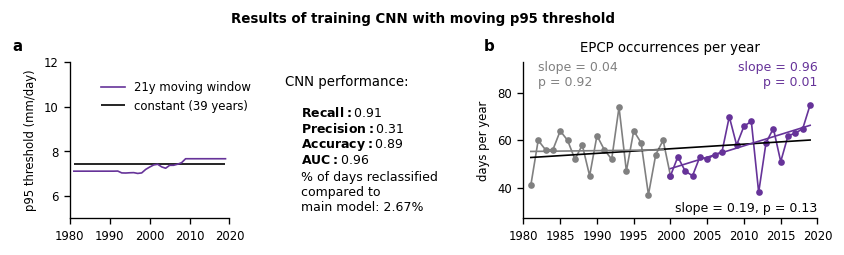

In [35]:
fig = plt.figure(figsize = (7, 2))

ax = fig.add_axes([0.08, 0.12, 0.19, 0.65])
ax.plot(p95_rolling21.year, p95_rolling21.p95_rolling21, color = moving_col, label = "21y moving window")
ax.hlines(p95, 1981, 2019, "k", label = "constant (39 years)")
ax.set(ylim = (5, 12), xlim = (1980, 2020), ylabel = "p95 threshold (mm/day)")
figu.format_plot(ax)
ax.legend(frameon=False, bbox_to_anchor = (1.2, 0.95))
figu.add_panel_label(ax, "a", x = -0.3)
fig.suptitle("Results of training CNN with moving p95 threshold", weight = "bold")

ax.text(x = 1.35, y = 0.85, s = "CNN performance:", transform = ax.transAxes, size = 8)
ax.text(x = 1.45, y = 0.65, s = r"$\bf{Recall: }$" + str(np.round(recall, 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.45, y = 0.55, s = r"$\bf{Precision: }$" + str(np.round(precision, 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.45, y = 0.45, s = r"$\bf{Accuracy: }$" + str(np.round(accuracy, 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.45, y = 0.35, s = r"$\bf{AUC: }$" + str(np.round(auc, 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.45, y = 0.05, s = "% of days reclassified\ncompared to\nmain model: " + 
        str(np.round(np.sum(diff)/len(class_predictions)*100, 2)) + "%", 
       transform = ax.transAxes, size = 7.5)

ax = fig.add_axes([0.62, 0.12, 0.35, 0.65])
x = epcp_annual.index
y = epcp_annual.values.squeeze()
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = moving_col)
## plot trend lines
ax.plot(x, x*trend_dat.iloc[0]['slope']+trend_dat.iloc[0]['int'], color = 'k')
ax.plot(x[early_ind], x[early_ind]*trend_dat.iloc[0]['slope_early']+trend_dat.iloc[0]['int_early'], 
        color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*trend_dat.iloc[0]['slope_late']+trend_dat.iloc[0]['int_late'], 
        color = moving_col)
## plot text
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(trend_dat.iloc[0]['slope'], 2)) + 
        ', p = ' + str(np.round(trend_dat.iloc[0]['pval'], 2)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(trend_dat.iloc[0]['slope_early'], 2)) + 
        '\np = ' + str(np.round(trend_dat.iloc[0]['pval_early'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = 'slope = ' + str(np.round(trend_dat.iloc[0]['slope_late'], 2)) + 
        '\np = ' + str(np.round(trend_dat.iloc[0]['pval_late'], 2)), 
       transform=ax.transAxes, size = 7.5, color = moving_col, horizontalalignment='right')
ax.set(title = 'EPCP occurrences per year', 
       ylim = (27,93), xlim = (1980, 2020), ylabel = "days per year")
figu.format_plot(ax)
figu.add_panel_label(ax, 'b')

fig.savefig("../figures/figure_S3.pdf")